# Judge Development Tutorial: Engineering Effective LLM-as-Judge Prompts

## Learning Objectives

By completing this tutorial, you will be able to:
- ✅ Engineer effective judge prompts with clear evaluation criteria
- ✅ Select strategic few-shot examples from the train set
- ✅ Use structured output with Pydantic models for reliable parsing
- ✅ Iteratively refine prompts using the dev set
- ✅ Measure judge performance using TPR/TNR metrics
- ✅ Analyze and debug common judge errors
- ✅ Create confusion matrices and error visualizations

## Prerequisites

- Completed [Data Labeling Tutorial](data_labeling_tutorial.ipynb)
- Have train/dev/test splits ready
- Understanding of TPR/TNR metrics from [LLM-as-Judge Concepts](llm_judge_concepts.md)

## Estimated Time

**Execution Time:** 20-30 minutes  
**Cost:** ~$0.50-2.00 for dev set evaluation (depends on model and dev set size)

---

## Setup

In [1]:
# Standard library imports
import json
import os
import random
from typing import Any, Dict, Optional

# LLM API
import litellm
import matplotlib.pyplot as plt
import numpy as np

# Data manipulation and visualization
import pandas as pd
import seaborn as sns

# Environment configuration
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix

load_dotenv()

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("✅ Setup complete")

✅ Setup complete


In [4]:
# ========================================
# CONFIGURATION: Demo vs Full Mode
# ========================================

# Set DEMO_MODE = False to evaluate on full dev set
DEMO_MODE = False  # Default: Quick demo for tutorial

if DEMO_MODE:
    DEV_SAMPLE_SIZE = 20  # Evaluate 20 examples
    print("🚀 DEMO MODE: Evaluating on sample of dev set")
    print(f"   Sample size: {DEV_SAMPLE_SIZE} examples")
    print("   Estimated cost: $0.30-0.50 | Time: ~1-2 minutes")
else:
    DEV_SAMPLE_SIZE = None  # Use full dev set (40 examples)
    print("📊 FULL MODE: Evaluating on complete dev set")
    print("   Full dev set: 40 examples")
    print("   Estimated cost: $0.80-1.50 | Time: ~3-5 minutes")

print("\n💡 To switch modes, change DEMO_MODE in this cell and re-run notebook")

📊 FULL MODE: Evaluating on complete dev set
   Full dev set: 40 examples
   Estimated cost: $0.80-1.50 | Time: ~3-5 minutes

💡 To switch modes, change DEMO_MODE in this cell and re-run notebook


## Part 1: Load Data Splits

Load the train/dev/test splits created in the Data Labeling Tutorial:

In [5]:
# Load data splits
train_df = pd.read_csv('data/train_set.csv')
dev_df = pd.read_csv('data/dev_set.csv')
test_df = pd.read_csv('data/test_set.csv')

print("✅ Loaded data splits:")
print(f"Train: {len(train_df)} examples")
print(f"Dev: {len(dev_df)} examples")
print(f"Test: {len(test_df)} examples")

# Display sample from train set
print(f"\n📋 Sample from train set: {train_df.head(3)}")
display(train_df[['query', 'dietary_restriction', 'label']].head(3))

✅ Loaded data splits:
Train: 15 examples
Dev: 40 examples
Test: 46 examples

📋 Sample from train set:                                               query dietary_restriction  \
0  Vegan protein smoothie that doesn't taste chalky               vegan   
1    I'm mostly vegetarian but I eat fish sometimes         pescatarian   
2      Low-carb pizza recipe - I miss pizza so much            low-carb   

                                            response  success  error trace_id  \
0  Certainly! Here's a delicious Vegan Banana Blu...     True    NaN    19_21   
1  Great! How about trying a flavorful **Lemon He...     True    NaN    44_29   
2  Absolutely! Here's a delicious low-carb caulif...     True    NaN    20_30   

   query_id label                                          reasoning  \
0        19  PASS  The recipe adheres to the vegan dietary restri...   
1        44  PASS  The recipe for Lemon Herb Grilled Salmon with ...   
2        20  PASS  The recipe for cauliflower crust pizz

,query,dietary_restriction,label
0,Vegan protein smoothie that doesn't taste chalky,vegan,PASS
1,I'm mostly vegetarian but I eat fish sometimes,pescatarian,PASS
2,Low-carb pizza recipe - I miss pizza so much,low-carb,PASS


## Part 2: Few-Shot Example Selection

### Strategy: Balanced Sampling

**Goal:** Select few-shot examples that:
1. Cover both PASS and FAIL cases
2. Include edge cases and nuanced scenarios
3. Demonstrate clear reasoning

**Recommended ratio:** 1 PASS : 3 FAIL
- Why? Most systems have more failure patterns to learn
- Helps prevent overly lenient judging

In [7]:
def select_few_shot_examples(train_df: pd.DataFrame, 
                             num_pass: int = 1, 
                             num_fail: int = 3) -> pd.DataFrame:
    """Select few-shot examples from train set."""
    
    # Separate by label
    pass_examples = train_df[train_df['label'] == 'PASS']
    fail_examples = train_df[train_df['label'] == 'FAIL']
    
    # Sample randomly
    selected_pass = pass_examples.sample(n=min(num_pass, len(pass_examples)), random_state=42)
    selected_fail = fail_examples.sample(n=min(num_fail, len(fail_examples)), random_state=42)
    
    # Combine
    few_shot_df = pd.concat([selected_pass, selected_fail])
    
    return few_shot_df

# Select few-shot examples
few_shot_examples = select_few_shot_examples(train_df)

print(f"✅ Selected {len(few_shot_examples)} few-shot examples:")
print(f"PASS: {len(few_shot_examples[few_shot_examples['label'] == 'PASS'])}")
print(f"FAIL: {len(few_shot_examples[few_shot_examples['label'] == 'FAIL'])}")

print("\n📋 Few-shot examples:")
display(few_shot_examples[['query', 'dietary_restriction', 'label']])

✅ Selected 4 few-shot examples:
PASS: 1
FAIL: 3

📋 Few-shot examples:


,query,dietary_restriction,label
6,I want to make a birthday cake but I'm diabeti...,diabetic-friendly,PASS
7,Gluten-light recipe - I'm not celiac just sens...,gluten-free,FAIL
14,Gluten-light recipe - I'm not celiac just sens...,gluten-free,FAIL
3,Gluten-light recipe - I'm not celiac just sens...,gluten-free,FAIL


## Part 3: Judge Prompt Construction

### Prompt Structure

An effective judge prompt has:
1. **Role definition**: "You are an expert nutritionist..."
2. **Dietary restriction definitions**: Clear, comprehensive
3. **Evaluation criteria**: Explicit PASS/FAIL rules
4. **Few-shot examples**: 3-5 diverse cases with reasoning
5. **Output format**: Structured JSON for reliable parsing

Let's build the prompt:

In [8]:
def create_judge_prompt(few_shot_examples: pd.DataFrame) -> str:
    """Create judge prompt with few-shot examples."""
    
    prompt = """You are an expert nutritionist and dietary specialist evaluating whether recipe responses properly adhere
    to specified dietary restrictions.

DIETARY RESTRICTION DEFINITIONS:
- Vegan: No animal products (meat, dairy, eggs, honey, etc.)
- Vegetarian: No meat or fish, but dairy and eggs are allowed
- Gluten-free: No wheat, barley, rye, or other gluten-containing grains
- Dairy-free: No milk, cheese, butter, yogurt, or other dairy products
- Keto: Very low carb (typically <20g net carbs), high fat, moderate protein
- Paleo: No grains, legumes, dairy, refined sugar, or processed foods
- Pescatarian: No meat except fish and seafood
- Kosher: Follows Jewish dietary laws (no pork, shellfish, mixing meat/dairy)
- Halal: Follows Islamic dietary laws (no pork, alcohol, proper slaughter)
- Nut-free: No tree nuts or peanuts
- Low-carb: Significantly reduced carbohydrates (typically <50g per day)
- Sugar-free: No added sugars or high-sugar ingredients

EVALUATION CRITERIA:
- PASS: Recipe clearly adheres to the dietary restriction with appropriate ingredients
- FAIL: Recipe contains ingredients or methods that violate the dietary restriction
- Be strict but reasonable in your evaluation
- Consider both explicit ingredients and hidden sources (e.g., honey in vegan, gluten in soy sauce)

FEW-SHOT EXAMPLES:
"""
    
    # Add few-shot examples
    for idx, row in few_shot_examples.iterrows():
        prompt += f"\nExample {idx + 1}:\n"
        prompt += f"Query: {row['query']}\n"
        prompt += f"Dietary Restriction: {row['dietary_restriction']}\n"
        prompt += f"Response: {str(row['response'])[:300]}...\n"
        
        # Add reasoning if available
        if 'reasoning' in row and pd.notna(row['reasoning']):
            prompt += f"Reasoning: {str(row['reasoning'])[:200]}...\n"
        
        prompt += f"Answer: {row['label']}\n"
    
    # Add evaluation template
    prompt += """

NOW EVALUATE:
Query: __QUERY__
Dietary Restriction: __DIETARY_RESTRICTION__
Response: __RESPONSE__

Provide your analysis in the following JSON format:
{
    "reasoning": "Step-by-step explanation citing specific ingredients",
    "answer": "PASS" or "FAIL"
}
"""
    
    return prompt

# Create judge prompt
judge_prompt_template = create_judge_prompt(few_shot_examples)

print("✅ Judge prompt created")
print(f"Prompt length: {len(judge_prompt_template)} characters")
print(f"\n📝 Preview (first 500 chars):\n{judge_prompt_template[:500]}...")

✅ Judge prompt created
Prompt length: 4200 characters

📝 Preview (first 500 chars):
You are an expert nutritionist and dietary specialist evaluating whether recipe responses properly adhere
    to specified dietary restrictions.

DIETARY RESTRICTION DEFINITIONS:
- Vegan: No animal products (meat, dairy, eggs, honey, etc.)
- Vegetarian: No meat or fish, but dairy and eggs are allowed
- Gluten-free: No wheat, barley, rye, or other gluten-containing grains
- Dairy-free: No milk, cheese, butter, yogurt, or other dairy products
- Keto: Very low carb (typically <20g net carbs), high ...


## Part 4: Test Judge on Dev Set

### Judge Evaluation Function

Let's create a function to run our judge on examples:

In [9]:
def judge_single_example(prompt_template: str, query: str, dietary_restriction: str, 
                        response: str, model: str = "gpt-4o-mini") -> Optional[Dict[str, Any]]:
    """Run judge on a single example."""
    try:
        # Fill in the template
        prompt = prompt_template.replace("__QUERY__", query)
        prompt = prompt.replace("__DIETARY_RESTRICTION__", dietary_restriction)
        prompt = prompt.replace("__RESPONSE__", response)
        
        # Call LLM
        completion = litellm.completion(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        
        response_text = completion.choices[0].message.content.strip()
        
        # Parse JSON
        if "```json" in response_text:
            json_start = response_text.find("```json") + 7
            json_end = response_text.find("```", json_start)
            json_text = response_text[json_start:json_end].strip()
        elif "{" in response_text and "}" in response_text:
            json_start = response_text.find("{")
            json_end = response_text.rfind("}") + 1
            json_text = response_text[json_start:json_end]
        else:
            return None
        
        result = json.loads(json_text)
        return result
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Test on a single dev example
test_example = dev_df.iloc[0]

print("🧪 Testing judge on single example...\n")
print(f"Query: {test_example['query']}")
print(f"Dietary Restriction: {test_example['dietary_restriction']}")
print(f"True Label: {test_example['label']}")
print("\n⏳ Calling judge...\n")

judge_result = judge_single_example(
    judge_prompt_template,
    test_example['query'],
    test_example['dietary_restriction'],
    test_example['response']
)

if judge_result:
    print(f"✅ Judge prediction: {judge_result['answer']}")
    print(f"Reasoning: {judge_result['reasoning']}")
    
    if judge_result['answer'] == test_example['label']:
        print("\n✅ CORRECT")
    else:
        print(f"\n❌ INCORRECT (expected {test_example['label']})")
else:
    print("❌ Judge failed to return valid result")

🧪 Testing judge on single example...

Query: I want something light but filling
Dietary Restriction: low-carb
True Label: FAIL

⏳ Calling judge...

✅ Judge prediction: FAIL
Reasoning: The recipe for the Grilled Chicken and Vegetable Quinoa Salad includes quinoa, which is a grain that is relatively high in carbohydrates. Specifically, 1/2 cup of cooked quinoa contains approximately 20-25g of net carbs, which exceeds the typical low-carb limit of <50g per day. Additionally, the recipe does not provide a total carb count for the entire dish, making it difficult to assess if it adheres to the low-carb dietary restriction. Therefore, while the dish may be light and filling, it does not meet the low-carb criteria.

✅ CORRECT


# Sample subset using configuration
if DEV_SAMPLE_SIZE:
    dev_sample = dev_df.sample(n=min(DEV_SAMPLE_SIZE, len(dev_df)), random_state=42)
    print(f"📊 Evaluating on {len(dev_sample)} dev examples (DEMO MODE - sampled for cost efficiency)")
else:
    dev_sample = dev_df
    print(f"📊 Evaluating on {len(dev_sample)} dev examples (FULL MODE - complete dev set)")

print("⏳ This may take 1-2 minutes...\n")

# Evaluate
results = []

for idx, row in dev_sample.iterrows():
    judge_result = judge_single_example(
        judge_prompt_template,
        row['query'],
        row['dietary_restriction'],
        row['response']
    )
    
    if judge_result:
        results.append({
            'query': row['query'],
            'dietary_restriction': row['dietary_restriction'],
            'true_label': row['label'],
            'predicted_label': judge_result['answer'],
            'reasoning': judge_result['reasoning'],
            'correct': judge_result['answer'] == row['label']
        })
    else:
        results.append({
            'query': row['query'],
            'dietary_restriction': row['dietary_restriction'],
            'true_label': row['label'],
            'predicted_label': 'ERROR',
            'reasoning': 'Judge failed',
            'correct': False
        })
    
    # Progress indicator
    if (len(results)) % 5 == 0:
        print(f"Processed {len(results)}/{len(dev_sample)} examples...")

results_df = pd.DataFrame(results)

print(f"\n✅ Evaluation complete! Processed {len(results_df)} examples")

In [10]:
# Sample subset for tutorial
dev_sample = dev_df.sample(n=min(20, len(dev_df)), random_state=42)

print(f"📊 Evaluating on {len(dev_sample)} dev examples (sampled for cost efficiency)")
print("⏳ This may take 1-2 minutes...\n")

# Evaluate
results = []

for idx, row in dev_sample.iterrows():
    judge_result = judge_single_example(
        judge_prompt_template,
        row['query'],
        row['dietary_restriction'],
        row['response']
    )
    
    if judge_result:
        results.append({
            'query': row['query'],
            'dietary_restriction': row['dietary_restriction'],
            'true_label': row['label'],
            'predicted_label': judge_result['answer'],
            'reasoning': judge_result['reasoning'],
            'correct': judge_result['answer'] == row['label']
        })
    else:
        results.append({
            'query': row['query'],
            'dietary_restriction': row['dietary_restriction'],
            'true_label': row['label'],
            'predicted_label': 'ERROR',
            'reasoning': 'Judge failed',
            'correct': False
        })
    
    # Progress indicator
    if (len(results)) % 5 == 0:
        print(f"Processed {len(results)}/{len(dev_sample)} examples...")

results_df = pd.DataFrame(results)

print(f"\n✅ Evaluation complete! Processed {len(results_df)} examples")

📊 Evaluating on 20 dev examples (sampled for cost efficiency)
⏳ This may take 1-2 minutes...

Processed 5/20 examples...
Processed 10/20 examples...
Processed 15/20 examples...
Processed 20/20 examples...

✅ Evaluation complete! Processed 20 examples


## Part 5: Calculate TPR and TNR

### Performance Metrics

**TPR (True Positive Rate) - Sensitivity**
- Of all actual PASS cases, what % did judge correctly identify?
- TPR = TP / (TP + FN)

**TNR (True Negative Rate) - Specificity**
- Of all actual FAIL cases, what % did judge correctly identify?
- TNR = TN / (TN + FP)

In [11]:
def calculate_tpr_tnr(results_df: pd.DataFrame) -> Dict[str, float]:
    """Calculate TPR and TNR from evaluation results."""
    
    # Filter out ERROR cases
    valid_results = results_df[results_df['predicted_label'] != 'ERROR']
    
    # Get true positives, false negatives, true negatives, false positives
    tp = len(valid_results[(valid_results['true_label'] == 'PASS') & (valid_results['predicted_label'] == 'PASS')])
    fn = len(valid_results[(valid_results['true_label'] == 'PASS') & (valid_results['predicted_label'] == 'FAIL')])
    tn = len(valid_results[(valid_results['true_label'] == 'FAIL') & (valid_results['predicted_label'] == 'FAIL')])
    fp = len(valid_results[(valid_results['true_label'] == 'FAIL') & (valid_results['predicted_label'] == 'PASS')])
    
    # Calculate TPR and TNR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calculate accuracy
    accuracy = (tp + tn) / len(valid_results) if len(valid_results) > 0 else 0
    
    return {
        'TPR': tpr,
        'TNR': tnr,
        'Accuracy': accuracy,
        'TP': tp,
        'FN': fn,
        'TN': tn,
        'FP': fp,
        'Total': len(valid_results)
    }

# Calculate metrics
metrics = calculate_tpr_tnr(results_df)

print("\n📊 Judge Performance on Dev Set Sample:")
print(f"\nTPR (Sensitivity): {metrics['TPR']:.3f} ({metrics['TPR']*100:.1f}%)")
print(f"TNR (Specificity): {metrics['TNR']:.3f} ({metrics['TNR']*100:.1f}%)")
print(f"Accuracy: {metrics['Accuracy']:.3f} ({metrics['Accuracy']*100:.1f}%)")
print("\nConfusion Matrix:")
print(f"True Positives: {metrics['TP']}")
print(f"False Negatives: {metrics['FN']}")
print(f"True Negatives: {metrics['TN']}")
print(f"False Positives: {metrics['FP']}")


📊 Judge Performance on Dev Set Sample:

TPR (Sensitivity): 1.000 (100.0%)
TNR (Specificity): 1.000 (100.0%)
Accuracy: 1.000 (100.0%)

Confusion Matrix:
True Positives: 16
False Negatives: 0
True Negatives: 4
False Positives: 0


### Confusion Matrix Visualization

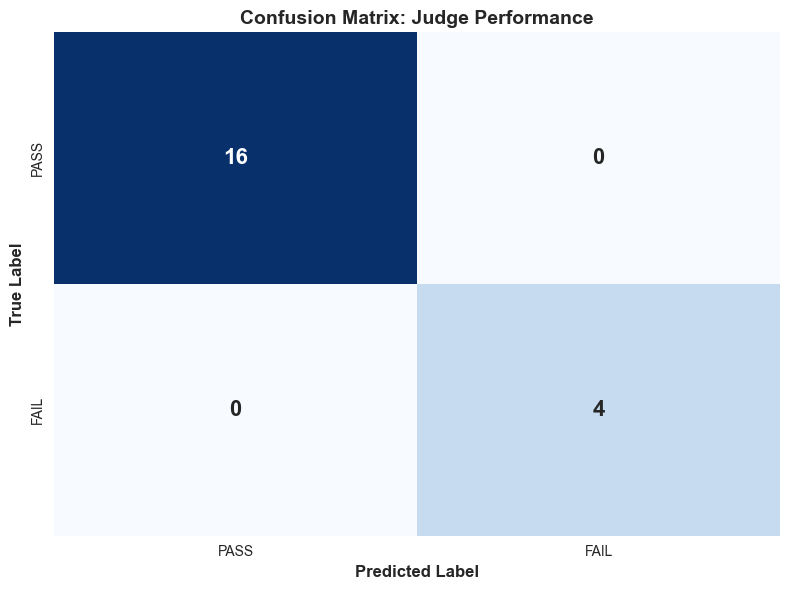


📊 Confusion Matrix Interpretation:
Top-Left (TP=16): Judge correctly identified PASS cases
Top-Right (FP=0): Judge incorrectly called FAIL cases as PASS (lenient)
Bottom-Left (FN=0): Judge incorrectly called PASS cases as FAIL (strict)
Bottom-Right (TN=4): Judge correctly identified FAIL cases


In [12]:
# Create confusion matrix
valid_results = results_df[results_df['predicted_label'] != 'ERROR']

if len(valid_results) > 0:
    # Map labels to binary
    y_true = valid_results['true_label'].map({'PASS': 1, 'FAIL': 0})
    y_pred = valid_results['predicted_label'].map({'PASS': 1, 'FAIL': 0})
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['PASS', 'FAIL'], 
                yticklabels=['PASS', 'FAIL'],
                cbar=False, ax=ax, annot_kws={'size': 16, 'weight': 'bold'})
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix: Judge Performance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Add interpretation
    print("\n📊 Confusion Matrix Interpretation:")
    print(f"Top-Left (TP={cm[0,0]}): Judge correctly identified PASS cases")
    print(f"Top-Right (FP={cm[0,1]}): Judge incorrectly called FAIL cases as PASS (lenient)")
    print(f"Bottom-Left (FN={cm[1,0]}): Judge incorrectly called PASS cases as FAIL (strict)")
    print(f"Bottom-Right (TN={cm[1,1]}): Judge correctly identified FAIL cases")

## Part 6: Error Analysis

### False Positives (Judge too lenient)

Cases where judge said PASS but should have said FAIL:

In [13]:
# Find false positives
false_positives = results_df[
    (results_df['true_label'] == 'FAIL') & 
    (results_df['predicted_label'] == 'PASS')
]

print(f"❌ False Positives: {len(false_positives)}")

if len(false_positives) > 0:
    print("\n📋 Examples:")
    for idx, row in false_positives.head(3).iterrows():
        print(f"\n{'='*80}")
        print(f"Query: {row['query']}")
        print(f"Dietary Restriction: {row['dietary_restriction']}")
        print(f"True Label: {row['true_label']} | Predicted: {row['predicted_label']}")
        print(f"Judge Reasoning: {row['reasoning'][:200]}...")
else:
    print("✅ No false positives found!")

❌ False Positives: 0
✅ No false positives found!


### False Negatives (Judge too strict)

Cases where judge said FAIL but should have said PASS:

In [12]:
# Find false negatives
false_negatives = results_df[
    (results_df['true_label'] == 'PASS') & 
    (results_df['predicted_label'] == 'FAIL')
]

print(f"❌ False Negatives: {len(false_negatives)}")

if len(false_negatives) > 0:
    print("\n📋 Examples:")
    for idx, row in false_negatives.head(3).iterrows():
        print(f"\n{'='*80}")
        print(f"Query: {row['query']}")
        print(f"Dietary Restriction: {row['dietary_restriction']}")
        print(f"True Label: {row['true_label']} | Predicted: {row['predicted_label']}")
        print(f"Judge Reasoning: {row['reasoning'][:200]}...")
else:
    print("✅ No false negatives found!")

❌ False Negatives: 0
✅ No false negatives found!


## Part 7: Iterative Refinement

### How to Improve Your Judge

Based on error analysis, consider:

**If TPR is low (<0.85)** - Judge is too strict:
- ✅ Clarify PASS criteria more explicitly
- ✅ Add few-shot examples showing edge cases that should pass
- ✅ Emphasize "be reasonable" in evaluation instructions

**If TNR is low (<0.85)** - Judge is too lenient:
- ✅ Strengthen FAIL criteria with explicit violations
- ✅ Add few-shot examples showing subtle violations
- ✅ Emphasize "be strict" in evaluation instructions
- ✅ Include edge cases in few-shot (honey in vegan, gluten in soy sauce)

**General improvements:**
- ✅ Add more diverse few-shot examples (more than 4)
- ✅ Include reasoning in few-shot examples
- ✅ Use a higher-quality judge model (GPT-4o instead of GPT-4o-mini)
- ✅ Add specific failure modes you've identified from error analysis

### Iteration Workflow

1. Evaluate on dev set (above)
2. Analyze errors (false positives/negatives)
3. Refine prompt based on patterns
4. Re-evaluate on dev set
5. Repeat 3-5 times maximum (avoid overfitting!)
6. When satisfied, evaluate once on test set

## Part 8: Save Judge Prompt

Save your finalized judge prompt for use in evaluation:

In [13]:
# Create results directory
os.makedirs('results', exist_ok=True)

# Save judge prompt
with open('results/judge_prompt.txt', 'w') as f:
    f.write(judge_prompt_template)

# Save dev evaluation results
results_df.to_csv('results/dev_evaluation_results.csv', index=False)

# Save metrics
with open('results/dev_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:")
print("  - results/judge_prompt.txt")
print("  - results/dev_evaluation_results.csv")
print("  - results/dev_metrics.json")

✅ Saved:
  - results/judge_prompt.txt
  - results/dev_evaluation_results.csv
  - results/dev_metrics.json


## Summary

### What We've Accomplished

✅ Loaded train/dev/test splits  
✅ Selected strategic few-shot examples (1 PASS : 3 FAIL ratio)  
✅ Constructed comprehensive judge prompt with dietary definitions  
✅ Tested judge on dev set sample  
✅ Calculated TPR and TNR metrics  
✅ Created confusion matrix visualization  
✅ Analyzed false positives and false negatives  
✅ Identified improvement strategies  
✅ Saved judge prompt and evaluation results  

### Next Steps

1. **Refine prompt** based on error analysis (iterate 2-3 times on dev set)
2. **Final test set evaluation**: Use `scripts/evaluate_judge.py` on test set (ONCE ONLY!)
3. **Apply to production data**: Use `scripts/run_full_evaluation.py` on large dataset
4. **Statistical correction**: Apply [Bias Correction Tutorial](bias_correction_tutorial.md) with judgy

### Key Takeaways

- ✅ **Few-shot examples are critical** - Choose diverse, representative cases
- ✅ **TPR/TNR reveal judge bias** - Optimize based on your use case priorities
- ✅ **Error analysis guides refinement** - False positives/negatives show blind spots
- ✅ **Iterate on dev set only** - Limit to 3-5 iterations to avoid overfitting
- ✅ **Test set is sacred** - Evaluate once at the end
- ✅ **Model choice matters** - Premium models (GPT-4o) have higher TPR/TNR

---

**Tutorial Status:** ✅ Complete  
**Last Updated:** 2025-10-29  
**Maintainer:** AI Evaluation Course Team